In [1]:
import nnts
import numpy as np
import pandas as pd
import scipy
import torch
import matplotlib.pyplot as plt

import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing as preprocessing
import nnts.torch.models
import nnts.torch.models.trainers as trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
from typing import List

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
def calculate_pearson(df):
    df = df.copy()
    df["y_lead"] = df[["y_lead_1", "unique_id"]].groupby("unique_id").shift(1)
    df = df.dropna()
    pearson = scipy.stats.pearsonr(df["y"], df["y_lead"])
    print(pearson)
    return pearson[0]


def copy_with_noise(x, level, lead):
    noisy_x = (
        x
        + (x.std() * np.random.randn(len(x)) * level)
        + (x.mean() * np.random.randn(len(x)) * level)
    )
    return noisy_x.shift(-lead)


def prepare_covariates(data, scenario):
    pearson = 0
    conts = []
    noise = 0
    if scenario.covariates > 0:
        data["y_lead_1"] = (
            data[["y", "unique_id"]]
            .groupby("unique_id")
            .transform(copy_with_noise, scenario.error, 1)
        )
        pearson = calculate_pearson(data)
        conts.append("y_lead_1")
    if scenario.covariates > 1:
        data["y_lead_2"] = (
            data[["y", "unique_id"]]
            .groupby("unique_id")
            .transform(copy_with_noise, scenario.error, 2)
        )
        conts.append("y_lead_2")
    if scenario.covariates > 2:
        data["y_lead_3"] = (
            data[["y", "unique_id"]]
            .groupby("unique_id")
            .transform(copy_with_noise, scenario.error, 3)
        )
        conts.append("y_lead_3")
    data = data.dropna()
    scenario.conts = conts
    scenario.pearson = pearson
    scenario.noise = noise
    return data, scenario

In [3]:
errors = {
    "us_births": np.linspace(0, 0.195, 8).tolist(),
    "tourism": np.linspace(0, 1.65, 8).tolist(),
    "solar": np.linspace(0, 0.702, 8).tolist(),
    "hospital": np.linspace(0, 1.65, 8).tolist(),
    "electricity": np.linspace(0, 1.65, 8).tolist(),
    "traffic": np.linspace(0, 0.6, 8).tolist(),
}

In [4]:
df, metadata = nnts.data.load("tourism")
params = nnts.models.Hyperparams()
splitter = nnts.data.PandasSplitter()

In [14]:
params.dropout = 0.1

In [15]:
scenario_list: List[nnts.experiments.CovariateScenario] = []
scenario_list.append(
    nnts.experiments.CovariateScenario(metadata.prediction_length, 0.0, covariates=0)
)
for covariates in [1, 2, 3]:
    for error in errors[metadata.dataset]:
        scenario = nnts.experiments.CovariateScenario(
            metadata.prediction_length, error, covariates=covariates
        )
        scenario_list.append(scenario)

In [16]:
for scenario in scenario_list[:1]:
    df, scenario = prepare_covariates(df, scenario)
    split_data = splitter.split(df, metadata)
    trn_dl, val_dl, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}"
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=f"results/base-lstm/{metadata.dataset}", filename=f"{name}.json"
        ),
        #nnts.loggers.PrintHandler(),
        project=f"base-lstm-{metadata.dataset}",
        run=name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )
    net = nnts.torch.models.BaseLSTM(
        nnts.torch.models.LinearModel,
        params,
        preprocessing.masked_mean_abs_scaling,
        scenario.covariates + 1,
    )
    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        f"results/{metadata.dataset}/{name}.pt",
        nnts.torch.data.datasets.seed_everything,
        logger=logger
        )
    evaluator = trner.train(trn_dl, val_dl)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

BaseLSTM(
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=1, bias=True)
    )
  )
  (encoder): BaseLSTMDecoder(
    (rnn): LSTM(2, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
)
setting seed
X_shape torch.Size([128, 38, 2])
X tensor(40856.9453)
hidden_shape torch.Size([2, 128, 40])
hidden tensor(0.)
out_0_shape torch.Size([128, 38, 40])
out_0 tensor(784.9762, grad_fn=<SumBackward0>)
out_1_shape torch.Size([2, 128, 40])
out_1 tensor(137.6730, grad_fn=<SumBackward0>)
out_2_shape torch.Size([2, 128, 40])
out_2 tensor(172.4156, grad_fn=<SumBackward0>)
input tensor(40856.9453)
output tensor(784.9762)


ValueError: Expected 1D or 2D array, got 0D array instead

In [ ]:
for scenario in scenario_list[:1]:
    df, scenario = prepare_covariates(df, scenario)
    split_data = splitter.split(df, metadata)
    trn_dl, val_dl, test_dl = nnts.data.map_to_dataloaders(split_data, metadata, scenario, params, nnts.torch.data.TorchTimeseriesDataLoaderFactory())
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}"
    net = nnts.torch.models.TsarLSTM(
        nnts.torch.models.LinearModel, params, preprocessing.masked_mean_abs_scaling, scenario.covariates +1
    )
    best_state_dict = trainers.train(
        net, trn_dl, val_dl, params, metadata, name, logger=None
    )
    best_state_dict = torch.load(name)
    net.load_state_dict(best_state_dict)
    y, y_hat = trainers.eval(
        net, test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(y, y_hat, metadata.freq, metadata.seasonality)
    print(test_metrics)

AttributeError: module 'nnts.torch.models' has no attribute 'TsarLSTM'

In [9]:
def add_y_hat(df, y_hat, prediction_length):
    i = 0
    df_list = []
    for name, group in df.groupby("unique_id", sort=False):
        group["y_hat"] = None
        group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
        i += 1
        df_list.append(group)
    return df_list


def plot(df_test, prediction_length, start_idx=0):
    num_plots = min(len(df_test), 4)
    fig, axes = plt.subplots(
        nrows=num_plots // 2 + num_plots % 2, ncols=min(num_plots, 2), figsize=(20, 10)
    )
    axes = np.ravel(axes)  # Flatten the axes array

    for idx, ax in enumerate(axes):
        if idx < len(df_test):
            df_test[start_idx + idx].set_index("ds").tail(prediction_length * 5)[['y', 'y_hat']].plot(
                ax=ax
            )
        else:
            ax.axis("off")  # Hide empty subplots if df_test length is less than 4
    return fig

/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_99751/2584033428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_99751/2584033428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_99751/2584033428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

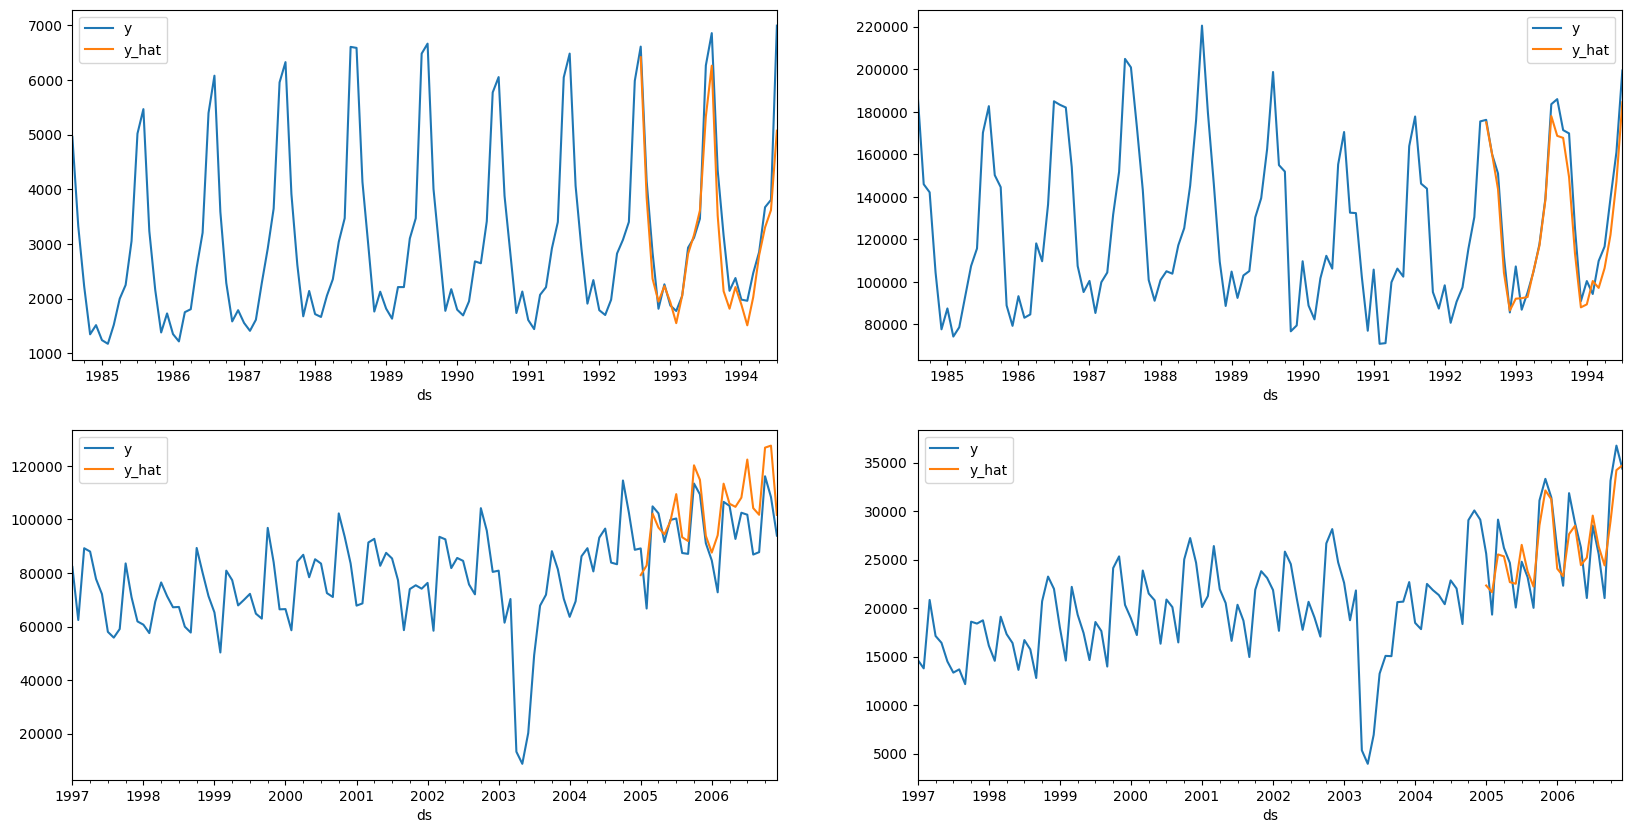

In [10]:
df_list = add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = plot(df_list, scenario.prediction_length)

In [11]:
 2 * (50 - 15 - 24)

22